<span style="font-size:50px;"> House Prices</span>

**Kaggle Competition**: [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

# PROJECT SETUP

## Load Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pipeline Diagram
from sklearn import set_config; set_config(display='diagram')

# Random Search
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Feature Selection
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

# Preprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectPercentile, mutual_info_regression

# Pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector

# Models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# Score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error, mean_squared_error, make_scorer

# Hide warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

## Scoring: `rmsle` and `rmse`

In [ ]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error, make_scorer

rmsle = make_scorer(lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred, squared=False))

rmse = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred)**0.5)
rmse_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_error(y_true, y_pred)**0.5)

## Load Dataset
- Train set: https://storage.googleapis.com/efcabinet/data/house_price_train.csv
- Test set: https://storage.googleapis.com/efcabinet/data/house-price-test.csv
- Submission sample: https://storage.googleapis.com/efcabinet/data/house-price-sample_submission.csv
- Data descripttion: https://storage.googleapis.com/efcabinet/data/house-price-data-description.txt

**Load the train dataset**

In [ ]:
data = pd.read_csv("https://storage.googleapis.com/efcabinet/data/house_price_train.csv")
data.shape

(1460, 81)

**Feature Engineering**

In [ ]:
# Converting non-numeric predictors stored as numbers into string
# data['MSSubClass'] = data['MSSubClass'].apply(str)

data.shape

(1460, 81)

**Create `X` for features and `y` for target**

In [ ]:
X = data.drop(columns=['SalePrice', 'Id'])
y = data.SalePrice
y_log = np.log(y)

In [ ]:
X['MoSold_sin'] = np.sin((X.MoSold-1)*(2.*np.pi/12))
X['MoSold_cos'] = np.cos((X.MoSold-1)*(2.*np.pi/12))
X.drop(columns=['MoSold'], inplace=True)
X.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,YrSold,SaleType,SaleCondition,MoSold_sin,MoSold_cos
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2008,WD,Normal,0.500000,0.866025
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,2007,WD,Normal,0.866025,-0.500000
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2008,WD,Normal,-0.866025,-0.500000


---

# ITERATIONS

## Preprocessing

### Encoding

In [ ]:
# In the pipeline for ordinal preprocessing, we'll fill_value='missing' to replace NaN

feat_ordinal_dict = {
    # considers "missing" as "neutral"
    "BsmtCond": ['missing', 'Po', 'Fa', 'TA', 'Gd'], #No Ex
    "BsmtExposure": ['missing', 'No', 'Mn', 'Av', 'Gd'], # 
    "BsmtFinType1": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], #No Partial
    # BsmtFinType1: "BLQ": "Below Average Living Quarters" vs "Rec": "Average Rec Room",
    "BsmtFinType2": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], #
    "BsmtQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'], #No Po
    "Electrical": ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'], #
    "ExterCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], #
    "ExterQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'], #
    "Fence": ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'], #Min Wood/Wire vs Min Privacy 
    "FireplaceQu": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], # 
    "Functional": ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'], #No Sal
    "GarageCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], #
    "GarageFinish": ['missing', 'Unf', 'RFn', 'Fin'], # 
    "GarageQual": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], # 
    "HeatingQC": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], #
    "KitchenQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'], #No Po
    "LandContour": ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'], # 
    "LandSlope": ['missing', 'Sev', 'Mod', 'Gtl'], #
    "LotShape": ['missing', 'IR3', 'IR2', 'IR1', 'Reg'], #
    "PavedDrive": ['missing', 'N', 'P', 'Y'],
    "PoolQC": ['missing', 'Fa', 'Gd', 'Ex'], #No Po
}

# OrdinalEncoder input (list of string or array-like of intergers or strings)
feat_ordinal = sorted(feat_ordinal_dict.keys()) # sort alphabetically

# OrdinalEncoder 'categories' parameter (a list of lists/array-like)
feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]

In [ ]:
feat_nominal = sorted(list(set(X.select_dtypes(include=["object"]).columns) - set(feat_ordinal))) # Convert to sorted list

In [ ]:
feat_numerical = sorted(X.select_dtypes(include=["int64", "float64"]).columns)

In [ ]:
feat_cyclical = sorted([
    "MoSold"  # Month Sold (MM)
])
feat_cyclical

['MoSold']

## Full Preprocessing Pipeline

In [ ]:
encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than "missing"
)

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    encoder_ordinal,
    MinMaxScaler()
)

preproc_numerical = make_pipeline(
    KNNImputer(),
    MinMaxScaler()
)

preproc_nominal = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore") # To ignore error message
)

preproc_transformer = make_column_transformer(
    (preproc_numerical, feat_numerical),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop")

# preproc_selector = SelectPercentile(
#     mutual_info_regression,
#     percentile=25, # keep only xx% of all features
# )

preproc = make_pipeline(
    preproc_transformer 
    # preproc_selector
)
preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['1stFlrSF', '2ndFlrSF',
                                                   '3SsnPorch', 'BedroomAbvGr',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtFullBath',
                                                   'BsmtHalfBath', 'BsmtUnfSF',
                                                   'EnclosedPorch',
                                                   'Fireplaces', 'FullBath',
                                                   'GarageArea', 'GarageCars',
                                                   'Gara...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Alley', 'BldgType',
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])]))])

**Encode whole dataset with the full preprocessing pipeline**

In [ ]:
pd.DataFrame(preproc.fit_transform(X, y_log)).shape

(1460, 217)

In [ ]:
pd.DataFrame(preproc.fit_transform(X, y_log)).head(2)

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,216
0,0.119780,0.413559,0.0,0.375,0.125089,0.0,0.333333,0.0,0.064212,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.212942,0.000000,0.0,0.375,0.173281,0.0,0.000000,0.5,0.121575,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


# TESTING MODELS

In [ ]:
allow_grid_searching = True # use True to activate girdsearch, False to deactive

# Cache the preprocessing step of the pipeline
from tempfile import mkdtemp
from shutil import rmtree
cachedir = mkdtemp()

## Linear Models (Lasso, Ridge, ElasticNet, SGDRegressor...)

In [ ]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression

In [ ]:
model_linear_regression = LinearRegression()
pipe_linreg = make_pipeline(preproc, model_linear_regression, memory=cachedir)
cross_val_score(pipe_linreg, X, y_log, cv=10, scoring=rmse).mean()

1412187430.1168573

In [ ]:
model_ridge = Ridge()
pipe_ridge = make_pipeline(preproc, model_ridge, memory=cachedir)
cross_val_score(pipe_ridge, X, y_log, cv=5, scoring=rmse).mean()

0.13855378989109343

In [ ]:
# GridSearch the Ridge regularization
if allow_grid_searching:
    param_grid =  {'ridge__alpha': np.linspace(0.5,2,num=20)}
    search_ridge = GridSearchCV(pipe_ridge, param_grid=param_grid, 
                              cv=5, n_jobs=-1, verbose=2, scoring=rmse_neg)

    search_ridge.fit(X, y_log);
    # print('Best estimator: ', search_ridge.best_estimator_)
    print('Best params: ', search_ridge.best_params_)
    print('Best RMSE (of log): ', -search_ridge.best_score_) # Inverse to turn into positive

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params:  {'ridge__alpha': 2.0}
Best RMSE (of log):  0.13734118600507728


## KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

model_knn = KNeighborsRegressor()
pipe_knn = make_pipeline(preproc, model_knn)
scores = cross_val_score(pipe_knn, X, y_log, cv=5, scoring=rmse, verbose=False)
print('Best RMSE (of log): ', scores.mean())

Best RMSE (of log):  0.20831550684405498


In [ ]:
# GridSearch the KNN
if allow_grid_searching:
    param_grid =  {'kneighborsregressor__n_neighbors': [3,4,5,6,7,8,9,10,15,20,30]}
    search_knn = GridSearchCV(pipe_knn, param_grid=param_grid, 
                              cv=3, n_jobs=-1, verbose=2, scoring=rmse_neg)

    search_knn.fit(X, y_log);
    print('Best params: ', search_knn.best_params_)
    print('Best RMSE (of log): ', -search_knn.best_score_) # Inverse to turn into positive

Fitting 3 folds for each of 11 candidates, totalling 33 fits
Best params:  {'kneighborsregressor__n_neighbors': 7}
Best RMSE (of log):  0.21030598163719624


## SVM

In [ ]:
model_svr_l = SVR(kernel='linear')
pipe_svm = make_pipeline(preproc, model_svr_l, memory=cachedir)
cross_val_score(pipe_svm, X, y_log, cv=5, scoring=rmse).mean()

0.1440302176420198

In [ ]:
model_svr_rbf = SVR(kernel='rbf', C = 10)
pipe_svm_rbf = make_pipeline(preproc, model_svr_rbf, memory=cachedir)
cross_val_score(pipe_svm_rbf, X, y_log, cv=5, scoring=rmse).mean()

0.13400913508010154

In [ ]:
# GridSearch
if allow_grid_searching:
    param_grid =  {'svr__C': [0.5, 0.7, 1, 2, 5, 10],
                  'svr__epsilon': [0.01, 0.05, 0.1, 0.2, 0.5],
                   'svr__coef0': [0.0, 0.1, 0.5,1],
                  }
    search_svm_rbf = GridSearchCV(pipe_svm_rbf, param_grid=param_grid, 
                              cv=5, n_jobs=-1, verbose=False, scoring=rmse_neg)

    search_svm_rbf.fit(X, y_log);
    print('Best estimator: ', search_svm_rbf.best_estimator_)
    print('Best params: ', search_svm_rbf.best_params_)
    print('Best RMSE (of log): ', -search_svm_rbf.best_score_) # Inverse to turn into positive

Best estimator:  Pipeline(memory='/var/folders/18/xyw20kr11mz0qymy_10fss5w0000gn/T/tmp4ie2iwo_',
         steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('knnimputer',
                                                                                    KNNImputer()),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['1stFlrSF',
                                                                    '2ndFlrSF',
                                                                    '3SsnPorch',
                                                                    'BedroomAbvGr',
             

## Trees

In [ ]:
from sklearn.tree import DecisionTreeRegressor

model_decision_tree_regressor = DecisionTreeRegressor(max_depth=50, min_samples_leaf=20)
pipe_decision_tree_regressor = make_pipeline(preproc, model_decision_tree_regressor, memory=cachedir)
score = cross_val_score(pipe_decision_tree_regressor, X, y_log, cv=5, scoring=rmse)
score.mean()

0.18931479383895605

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(max_depth=50,min_samples_leaf=20)
pipe_rf = make_pipeline(preproc, model_rf, memory=cachedir)
score = cross_val_score(pipe_rf, X, y_log, cv=5, scoring=rmse)
score.mean()

0.16224793725790768

## Boosted Trees

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

model_ada = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=None))

pipe_ada = make_pipeline(preproc, model_ada, memory=cachedir)
score = cross_val_score(pipe_ada, X, y_log, cv=5, scoring=rmse)
score.mean()

0.1402346794225529

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

model_xgboost = GradientBoostingRegressor(n_estimators=100, verbose=0)
pipe_gb = make_pipeline(preproc, model_xgboost, memory=cachedir)
score = cross_val_score(pipe_gb, X, y_log, cv=5, scoring=rmse)
score.mean()

0.12639867093332918

Best params:  {'gradientboostingregressor__learning_rate': 0.0998865672595152, 'gradientboostingregressor__loss': 'huber', 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__max_features': 64, 'gradientboostingregressor__min_samples_split': 4, 'gradientboostingregressor__n_estimators': 244, 'gradientboostingregressor__subsample': 0.95}
RMSE (of log):  0.12114903151024078


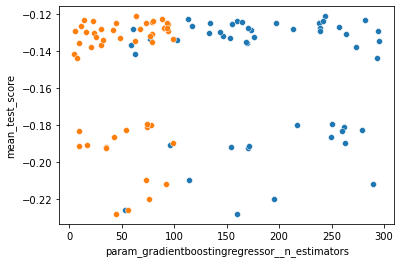

In [ ]:
if allow_grid_searching:
    grid = {
        'gradientboostingregressor__n_estimators': stats.randint(50,300),
        'gradientboostingregressor__learning_rate':stats.uniform(0.05,0.3),
        'gradientboostingregressor__loss': ['ls', 'lad', 'huber', 'quantile'],
        'gradientboostingregressor__max_depth': stats.randint(3,5),
        'gradientboostingregressor__min_samples_split': stats.randint(2,10),
        'gradientboostingregressor__subsample': [0.95, 1], # 1 default
        'gradientboostingregressor__max_features': stats.randint(2,100), # default None, i.e = n_features
    }

    search_gb = RandomizedSearchCV(pipe_gb, 
                                   grid, 
                                   scoring=rmse_neg, 
                                   n_iter=50, 
                                   cv=5, 
                                   n_jobs=-1, 
                                   verbose=False,)

    # Fit data to Grid Search
    search_gb.fit(X, y_log);
    print('Best params: ', search_gb.best_params_)
    print('RMSE (of log): ', -search_gb.best_score_)
    
    # Plot results of gridsearch
    df_cv_results_ = pd.DataFrame(search_gb.cv_results_)
    sns.scatterplot(x="param_gradientboostingregressor__n_estimators", y='mean_test_score', data=df_cv_results_)
    sns.scatterplot(x="param_gradientboostingregressor__max_features", y='mean_test_score', data=df_cv_results_)

## Stacking

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor

gboost = GradientBoostingRegressor(n_estimators=100)
ridge = Ridge()
svm = SVR(C=1, epsilon=0.05)
adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None))


model_voting_reg = VotingRegressor(
    estimators = [("gboost", gboost),("adaboost", adaboost),("ridge", ridge), ("svm_rbf", svm)],
    weights = [1,1,1,1], # to equally weight the two models
    n_jobs=-1
)

pipe_ensemble = make_pipeline(preproc, model_voting_reg, memory=cachedir)

score = cross_val_score(pipe_ensemble, X, y_log, cv=5, scoring=rmse, n_jobs=-1)
score.mean()

0.12025256163301815

In [ ]:
from sklearn.ensemble import StackingRegressor

gboost = GradientBoostingRegressor(n_estimators=100)
ridge = Ridge()
svm = SVR(C=1, epsilon=0.05)
adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None))

model_stacking_reg = StackingRegressor(
    estimators=[("gboost", gboost),
                ("adaboost", adaboost),
                ("ridge", ridge),
                ("svm_rbf", svm)],
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1
)

pipe_stacking_1 = make_pipeline(preproc, model_stacking_reg, memory=cachedir)
score = cross_val_score(pipe_stacking_1, X, y_log, cv=5, scoring=rmse, n_jobs=-1)
score.mean()

0.1190762653604445

## XGBoost

In [ ]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(max_depth=10, n_estimators=300, learning_rate=0.1)
pipe_xgb = make_pipeline(preproc, model_xgb)
cross_val_score(pipe_xgb, X, y_log, cv=5, scoring=rmse, n_jobs=-1).mean()

0.12906759130738804

Best Validation Score 0.140842


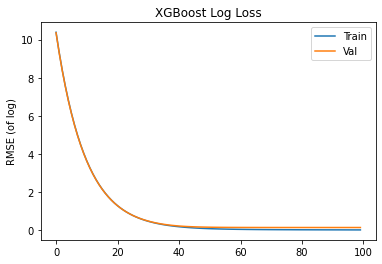

In [ ]:
X_train, X_eval, y_train_log, y_eval_log = train_test_split(X,y_log,random_state=42)

X_train_preproc = preproc.fit_transform(X_train, y_train_log)
X_eval_preproc = preproc.transform(X_eval)

model_xgb.fit(X_train_preproc, y_train_log,
        verbose=False,
        eval_set=[(X_train_preproc, y_train_log), (X_eval_preproc, y_eval_log)],
        eval_metric=["rmse"],
        early_stopping_rounds=10)

# retrieve performance metrics
results = model_xgb.evals_result()
epochs = len(results['validation_0']["rmse"])
x_axis = range(0, epochs)

# plot rmsle loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Val')
ax.legend(); plt.ylabel('RMSE (of log)'); plt.title('XGBoost Log Loss')

print("Best Validation Score", min(results['validation_1']['rmse']))

# OTHER MODEL TESTINGS

In [ ]:
from sklearn.ensemble import StackingRegressor

gboost = GradientBoostingRegressor(n_estimators=100)
ridge = Ridge()
svm = SVR(C=1, epsilon=0.05)
adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None))
knn = KNeighborsRegressor()
xgb = XGBRegressor(max_depth=3, n_estimators=2000, learning_rate=0.05)

model_stacking_2 = StackingRegressor(
    estimators=[("gboost", gboost),
                ("adaboost", adaboost),
                ("ridge", ridge),
                ("svm_rbf", svm),
                ("knn", knn),
                ("xgb", xgb)],
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1
)

pipe_stacking_2 = make_pipeline(preproc, model_stacking_2, memory=cachedir)
score = cross_val_score(pipe_stacking_2, X, y_log, cv=5, scoring=rmse, n_jobs=-1)
score.mean()

0.11700522598413146

**Use best gboost params from grid search**

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.ensemble import StackingRegressor

gboost = GradientBoostingRegressor(
    learning_rate = 0.092, 
    loss = 'squared_error',
    max_depth = 4,
    max_features = 23,
    min_samples_split = 2,
    n_estimators = 274,
    subsample = 1)
ridge = Ridge()
svm = SVR(C=2, epsilon=0.05)
adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None))
knn = KNeighborsRegressor()
xgb = XGBRegressor(max_depth=3, n_estimators=2000, learning_rate=0.05)

model_stacking_3 = StackingRegressor(
    estimators=[("gboost", gboost),
                ("adaboost", adaboost),
                ("ridge", ridge),
                ("svm_rbf", svm),
                ("knn", knn),
                ("xgb", xgb)],
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1
)

pipe_stacking_3 = make_pipeline(preproc, model_stacking_3, memory=cachedir)
score = cross_val_score(pipe_stacking_3, X, y_log, cv=5, scoring=rmse, n_jobs=-1)
score.mean()

0.1163791985608453

## CatBoostRegressor

In [ ]:
# !pip install catboost

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)


from catboost import CatBoostRegressor

params = {'iterations': 6000,
          'learning_rate': 0.005,
          'depth': 4,
          'l2_leaf_reg': 1,
          'eval_metric':'RMSE',
          'early_stopping_rounds': 200,
          'verbose': False,
          'random_seed': 42}
cat_f = CatBoostRegressor(**params)

pipe_cat = make_pipeline(preproc, cat_f, memory=cachedir)
score = cross_val_score(pipe_cat, X, y_log, cv=5, scoring=rmse)
score.mean()

0.11799059634803322

In [ ]:
preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['1stFlrSF', '2ndFlrSF',
                                                   '3SsnPorch', 'BedroomAbvGr',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtFullBath',
                                                   'BsmtHalfBath', 'BsmtUnfSF',
                                                   'EnclosedPorch',
                                                   'Fireplaces', 'FullBath',
                                                   'GarageArea', 'GarageCars',
                                                   'Gara...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Alley', 'BldgType',
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])]))])

## Test Blending

In [ ]:
X.shape

(1460, 80)

In [ ]:
preproc.fit(X, y_log)
X_processed = preproc.transform(X)
X_processed.shape

(1460, 217)

In [ ]:
train = X_processed
target = y_log

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

gboost = GradientBoostingRegressor(
    learning_rate = 0.092, 
    loss = 'squared_error',
    max_depth = 4,
    max_features = 23,
    min_samples_split = 2,
    n_estimators = 274,
    subsample = 1).fit(train, target)
ridge = Ridge().fit(train, target)
svm = SVR(C=2, epsilon=0.05).fit(train, target)
adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None)).fit(train, target)
knn = KNeighborsRegressor().fit(train, target)
xgb = XGBRegressor(max_depth=3, n_estimators=2000, learning_rate=0.05).fit(train, target)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

def blended_predict(X):
    return ((0.1 * ridge.predict(X)) + \
            (0.2 * gboost.predict(X)) + \
            (0.1 * adaboost.predict(X)) + \
            (0.2 * xgb.predict(X)) + \
            (0.1 * knn.predict(X)) + \
            (0.3 * svm.predict(X)))

def rmse_blend(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# Get final precitions from the blended model
blended_score = rmse_blend(target, blended_predict(train))
print('RMSE score (of log) on train data:')
print(blended_score)

RMSE score (of log) on train data:
0.05031734421397502


# Kaggle Submission

In [ ]:
preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['1stFlrSF', '2ndFlrSF',
                                                   '3SsnPorch', 'BedroomAbvGr',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtFullBath',
                                                   'BsmtHalfBath', 'BsmtUnfSF',
                                                   'EnclosedPorch',
                                                   'Fireplaces', 'FullBath',
                                                   'GarageArea', 'GarageCars',
                                                   'Gara...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Alley', 'BldgType',
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])]))])

In [ ]:
X_test = pd.read_csv("https://storage.googleapis.com/efcabinet/data/house-price-test.csv")
X_test_ids = X_test['Id'] # Keep ids
X_test = X_test.drop(columns=['Id'])
X_test

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [ ]:
X_test['MoSold_sin'] = np.sin((X_test.MoSold-1)*(2.*np.pi/12))
X_test['MoSold_cos'] = np.cos((X_test.MoSold-1)*(2.*np.pi/12))
X_test.drop(columns=['MoSold'], inplace=True)
X_test.shape

(1459, 80)

In [ ]:
preproc.fit(X,y_log)
X_test_processed = preproc.transform(X_test)
X_test_processed.shape

(1459, 217)

**Blending methods**

In [ ]:
predictions_logs = blended_predict(X_test_processed)

In [ ]:
predictions = np.floor(np.exp(predictions_logs))
predictions

array([124104., 151482., 180579., ..., 155446., 113784., 218870.])

In [ ]:
results = pd.concat([X_test_ids, pd.Series(predictions, name="SalePrice")], axis=1)
results

,Id,SalePrice
0,1461,124104.0
1,1462,151482.0
2,1463,180579.0
3,1464,193454.0
4,1465,187332.0
...,...,...
1454,2915,80986.0
1455,2916,81803.0
1456,2917,155446.0
1457,2918,113784.0


In [ ]:
# Export to Kaggle format submission and submit it online!
results.to_csv("submission_blending.csv", header=True, index=False)

**Stacking methods**

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

pipe_stacking_2.fit(X,y_log)
predictions_log_2 = pipe_stacking_2.predict(X_test)
predictions_2 = np.floor(np.exp(predictions_log_2))

In [ ]:
results_2 = pd.concat([X_test_ids, pd.Series(predictions_2, name="SalePrice")], axis=1)
results_2

,Id,SalePrice
0,1461,119899.0
1,1462,155968.0
2,1463,182115.0
3,1464,193459.0
4,1465,187727.0
...,...,...
1454,2915,78440.0
1455,2916,79013.0
1456,2917,159188.0
1457,2918,111117.0


In [ ]:
results.to_csv("submission_stacking.csv", header=True, index=False)

In [ ]:
# Clear the cache directory at the end
rmtree(cachedir)